# Embedding Comparison

### 🎯 Objectives
In this notebook we perform a detailed evaluation of the different embeddings generated. We will compare these embeddings:
- Sentence embeddings generated by `all-MiniLM-L6-v2`
- GNN node embeddings
- Node2Vec embeddings
- Multimodal (Node2Vec + Sentence) self-attention based embeddings
- Multimodal (Node2Vec + Sentence) self-attention based embeddings enhanced

Finally as a bonus we look at differnt visualization of our embeddings graph.

### ⚙️ Setup
- Remember to set `subreddit_name` to the name of your subreddit since multiple scripts rely on that file notation.

---

## Part 0: Load Data

### Setup GPU and CPU

In [1]:
import multiprocessing

# Determine the number of CPU cores available for parallel processing
n_jobs = max(1, multiprocessing.cpu_count() - 2)
print(f"Number of CPU cores available: {n_jobs}")

Number of CPU cores available: 30


In [2]:
import torch

# Check if CUDA-enabled GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Device Count: {torch.cuda.device_count()}")
else:
    print("GPU is not available. Using CPU.")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print(f"Torch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

GPU is available!
GPU Name: NVIDIA GeForce RTX 4070 SUPER
Device Count: 1
Using device: cuda
Torch version: 2.6.0+cu126
CUDA version: 12.6


### Global Parameters

In [3]:
subreddit_name = "AITAH"  # You can change this to any subreddit name
debugging_mode = False  # Set to True for debugging mode, uses a smaller dataset
debugging_mode_samples = 20000  # Number of samples to use in debugging mode

### Load Embeddings

In [4]:
import numpy as np
import os
# Define the directory path
embeddings_dir = f"../data/{subreddit_name}/embeddings/"

# List of embedding types to load
embedding_types = ["sentence", "gnn", "node2vec", "concat", "simple_attention", "enhanced_attention"]

# Dictionary to store all loaded embeddings
embeddings = {}

# Load each embedding file
for embed_type in embedding_types:
    file_path = os.path.join(embeddings_dir, f"{embed_type}_embeddings.npy")
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the embedding
        full_embeddings = np.load(file_path)
        
        # If in debugging mode, keep only the first debugging_mode_samples embeddings
        if debugging_mode and len(full_embeddings) > debugging_mode_samples:
            embeddings[embed_type] = full_embeddings[:debugging_mode_samples]
            print(f"Loaded {embed_type} embeddings with shape: {embeddings[embed_type].shape} (limited to 1000 for debugging)")
        else:
            embeddings[embed_type] = full_embeddings
            print(f"Loaded {embed_type} embeddings with shape: {embeddings[embed_type].shape}")
    else:
        print(f"Warning: Could not find {file_path}")

Loaded sentence embeddings with shape: (100000, 384)
Loaded gnn embeddings with shape: (100000, 384)
Loaded node2vec embeddings with shape: (100000, 384)
Loaded concat embeddings with shape: (100000, 768)
Loaded simple_attention embeddings with shape: (100000, 384)
Loaded enhanced_attention embeddings with shape: (100000, 384)


## Part 1: Compute t-SNE

### Compute t-SNE with CPU

In [5]:
from sklearn.manifold import TSNE
import pickle
import os
import time

# Create TSNE object once
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=n_jobs, verbose=0)

# Dictionary to store the 2D embeddings
embeddings_2d = {}

# Dictionary to store computation times
tsne_computation_times = {}

# Process each embedding in the dictionary
for embed_type, embed_data in embeddings.items():
    print(f"Computing t-SNE for {embed_type} embeddings...")
    
    # Start timer
    start_time = time.time()
    
    # Compute t-SNE
    embeddings_2d[embed_type] = tsne.fit_transform(embed_data)
    
    # Record computation time
    computation_time = time.time() - start_time
    tsne_computation_times[embed_type] = computation_time
    
    print(f"\tt-SNE for {embed_type} computed in {computation_time:.2f} seconds")
    
    # Create output directory if it doesn't exist
    os.makedirs(f"../data/{subreddit_name}/embeddings", exist_ok=True)
    
    # Save as pickle file
    output_path = f"../data/{subreddit_name}/embeddings/{embed_type}_embeddings_2d.pkl"
    with open(output_path, 'wb') as f:
        pickle.dump(embeddings_2d[embed_type], f)
    
    print(f"\tt-SNE for {embed_type} embeddings saved successfully.")

print("\nComputation times summary:")
for embed_type, comp_time in tsne_computation_times.items():
    print(f"{embed_type}: {comp_time:.2f} seconds")

Computing t-SNE for sentence embeddings...
	t-SNE for sentence computed in 159.49 seconds
	t-SNE for sentence embeddings saved successfully.
Computing t-SNE for gnn embeddings...
	t-SNE for gnn computed in 141.03 seconds
	t-SNE for gnn embeddings saved successfully.
Computing t-SNE for node2vec embeddings...
	t-SNE for node2vec computed in 187.02 seconds
	t-SNE for node2vec embeddings saved successfully.
Computing t-SNE for concat embeddings...
	t-SNE for concat computed in 207.20 seconds
	t-SNE for concat embeddings saved successfully.
Computing t-SNE for simple_attention embeddings...
	t-SNE for simple_attention computed in 175.12 seconds
	t-SNE for simple_attention embeddings saved successfully.
Computing t-SNE for enhanced_attention embeddings...
	t-SNE for enhanced_attention computed in 158.75 seconds
	t-SNE for enhanced_attention embeddings saved successfully.

Computation times summary:
sentence: 159.49 seconds
gnn: 141.03 seconds
node2vec: 187.02 seconds
concat: 207.20 seconds


## Part 2: Plot t-SNE
- Standard t-SNE plot with transparcy to see more dense areas
- Hexbin plot wiht logarithmic coloroing

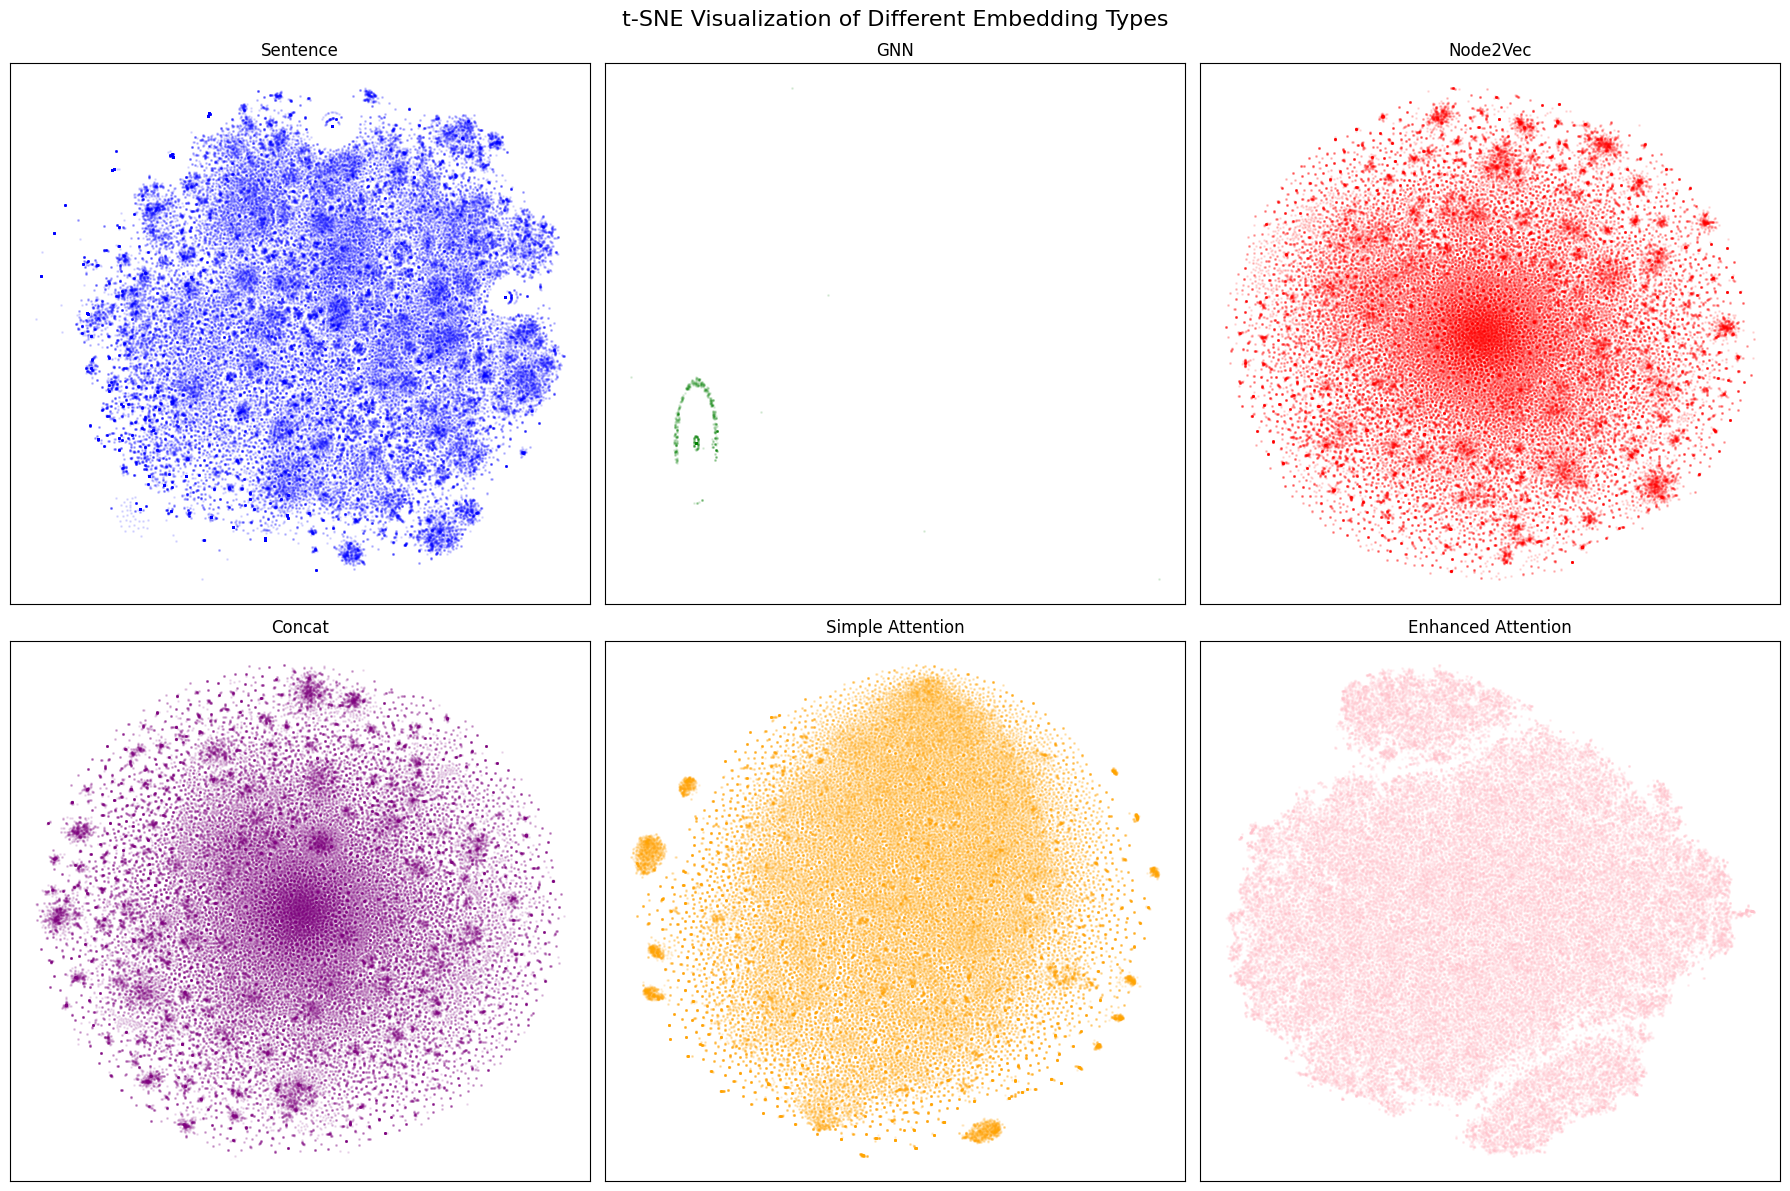

In [6]:
import matplotlib.pyplot as plt
import math

# Define colors for each embedding type
colors = {
    'sentence': 'blue',
    'gnn': 'green',
    'node2vec': 'red',
    'concat': 'purple',
    'simple_attention': 'orange',
    'enhanced_attention': 'pink'
}

names = {
    'sentence': 'Sentence',
    'gnn': 'GNN',
    'node2vec': 'Node2Vec',
    'concat': 'Concat',
    'simple_attention': 'Simple Attention',
    'enhanced_attention': 'Enhanced Attention'
}

# Calculate grid dimensions
num_embeddings = len(embeddings_2d)
grid_size = math.ceil(math.sqrt(num_embeddings))
fig_size = 6 * grid_size  # Adjust figure size based on grid

# Create figure and subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(fig_size, fig_size))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each embedding in its own subplot
for i, (embed_type, embed_data_2d) in enumerate(embeddings_2d.items()):
    ax = axes[i]
    
    # Plot the t-SNE results
    ax.scatter(
        embed_data_2d[:, 0], 
        embed_data_2d[:, 1], 
        alpha=0.1, 
        c=colors.get(embed_type, 'gray'),
        s=1
    )
    
    # Set title and remove ticks for cleaner look
    ax.set_title(names.get(embed_type, embed_type), fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Add overall title
plt.suptitle("t-SNE Visualization of Different Embedding Types", fontsize=16, y=0.98)

# Adjust layout and save
plt.tight_layout()
fig.subplots_adjust(top=0.95)  # Make room for suptitle
plt.savefig(f'./figures/{subreddit_name}/tsne_all_embeddings_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

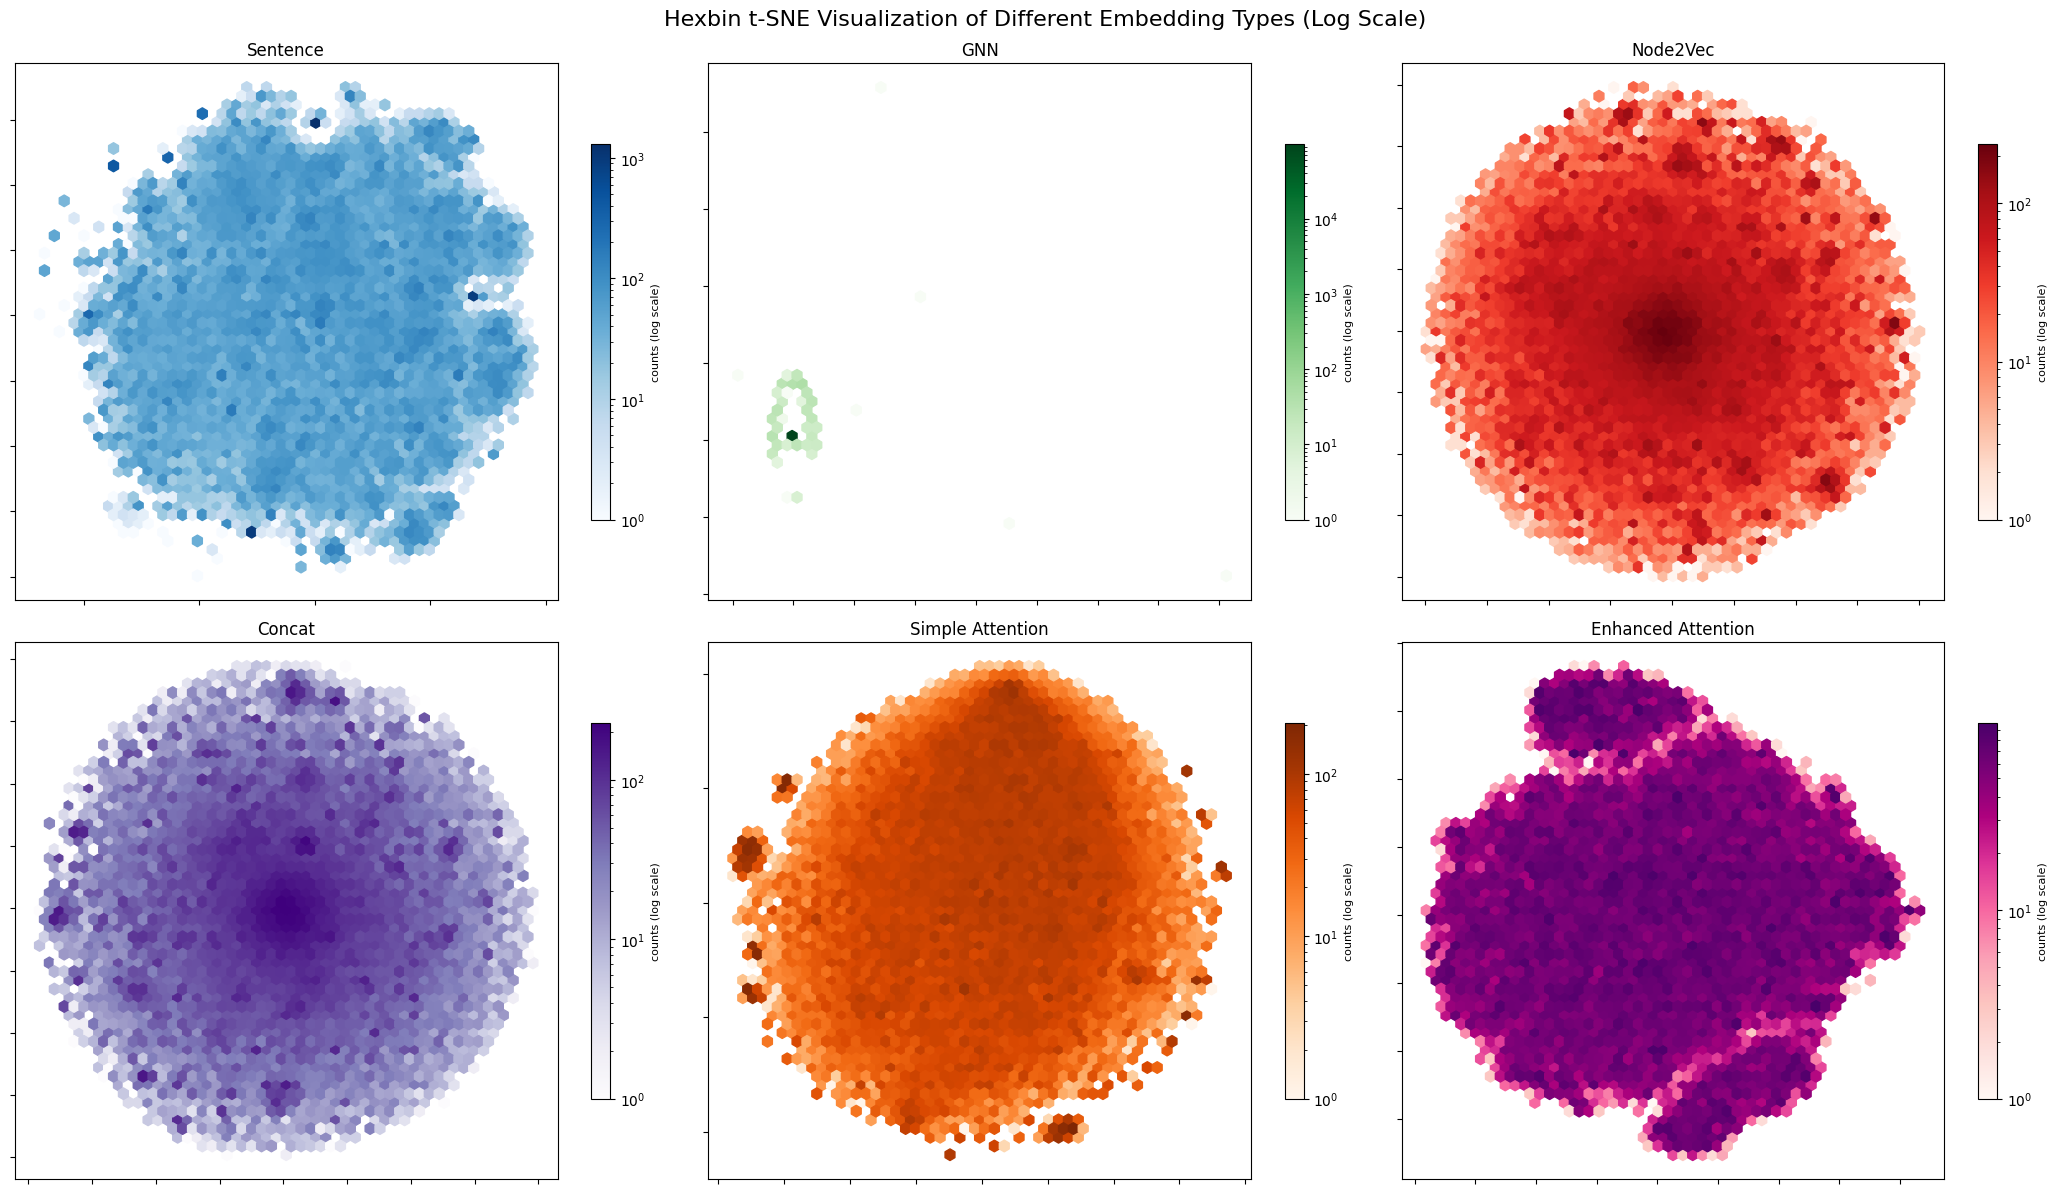

In [7]:
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm

# Define color maps for each embedding type
cmaps = {
    'sentence': 'Blues',
    'gnn': 'Greens',
    'node2vec': 'Reds',
    'concat': 'Purples',
    'simple_attention': 'Oranges',
    'enhanced_attention': 'RdPu'
}

# Calculate grid dimensions
num_embeddings = len(embeddings_2d)
grid_size = math.ceil(math.sqrt(num_embeddings))
fig_size = 6 * grid_size  # Adjust figure size based on grid

# Create figure and subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(fig_size + 3, fig_size))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each embedding in its own subplot
for i, (embed_type, embed_data_2d) in enumerate(embeddings_2d.items()):
    ax = axes[i]
    
    # Plot the t-SNE results using hexbin
    hb = ax.hexbin(
        embed_data_2d[:, 0],
        embed_data_2d[:, 1],
        gridsize=50,
        cmap=cmaps.get(embed_type, 'viridis'),
        mincnt=1,
        norm=LogNorm()  # Apply logarithmic normalization
    )
    
    # Add colorbar
    cbar = fig.colorbar(hb, ax=ax, shrink=0.7)
    cbar.set_label('counts (log scale)', fontsize=8)
    
    # Set title
    ax.set_title(names.get(embed_type, embed_type), fontsize=12)
    
    # Remove tick labels for cleaner look
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Add overall title
plt.suptitle("Hexbin t-SNE Visualization of Different Embedding Types (Log Scale)", fontsize=16, y=0.98)

# Adjust layout and save
plt.tight_layout()
fig.subplots_adjust(top=0.95)  # Make room for suptitle
plt.savefig(f'./figures/{subreddit_name}/tsne_all_embeddings_hexbin_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 3: Graph Visualization
As a bonus, we can attempt to visualize our graph representation. Remebr the graph is built by creates a node for each embeddings, and connecting nodes to their `k` most similar embeddings.

Graph visualization can be hard because of the huge amount of nodes and edges present.

### Load Graph

### Graph Visualizaions
- Standard full graph structure
- Sampled graph structure
- Largest connected component
- Aggregated graph structure

**UNTESTED**

In [8]:
# # Visualize Graph Structure
# plt.figure(figsize=(10, 6))
# nx.draw(G, with_labels=False, node_size=20)
# plt.title("Graph Structure of Similar Comments")
# plt.savefig('./figures/graph_structure.png', dpi=300, bbox_inches='tight')
# plt.show()

In [9]:
# import random
# import matplotlib.pyplot as plt

# # Sample and visualize the graph structure
# sample_size = 1000  # For example, use 1,000 nodes

# # Sample nodes from the graph (if the graph is larger than sample_size)
# if len(G.nodes()) > sample_size:
#     sampled_nodes = random.sample(list(G.nodes()), sample_size)
#     G_sub = G.subgraph(sampled_nodes)
# else:
#     G_sub = G

# plt.figure(figsize=(10, 6))
# nx.draw(G_sub, with_labels=False, node_size=20)
# plt.title("Graph Structure of Similar Comments (1000 Random Samples)")
# plt.savefig('./figures/graph_structure_sampled.png', dpi=300, bbox_inches='tight')
# plt.show()

In [10]:
# # Identify the largest connected component
# largest_cc = max(nx.connected_components(G), key=len)
# G_lcc = G.subgraph(largest_cc)

# plt.figure(figsize=(10, 6))
# nx.draw(G_lcc, with_labels=False, node_size=20)
# plt.title("Graph Structure of Similar Comments (Largest Connected Component)")
# plt.savefig('./figures/graph_structure_lcc.png', dpi=300, bbox_inches='tight')
# plt.show()

In [11]:
# import community as community_louvain  # Requires the python-louvain package

# # Compute communities (each node will be assigned a community label)
# partition = community_louvain.best_partition(G)

# # Create a new graph where each node is a community and edge weights reflect inter-community connections.
# aggregated_edges = {}
# for node1, node2 in G.edges():
#     comm1 = partition[node1]
#     comm2 = partition[node2]
#     if comm1 != comm2:
#         aggregated_edges[(comm1, comm2)] = aggregated_edges.get((comm1, comm2), 0) + 1

# # Construct the community graph
# G_comm = nx.Graph()
# for (comm1, comm2), weight in aggregated_edges.items():
#     G_comm.add_edge(comm1, comm2, weight=weight)

# plt.figure(figsize=(10, 6))
# pos = nx.spring_layout(G_comm)
# nx.draw(G_comm, pos, with_labels=True, node_size=300)
# plt.title("Aggregated Graph Structure via Community Detection")
# plt.savefig('./figures/graph_structure_aggregated.png', dpi=300, bbox_inches='tight')
# plt.show()